In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [7]:
# Use a random seed to have the same aleatorization every runtime.
DOMAIN_MAX = 32.768
DOMAIN_MIN = -DOMAIN_MAX
np.random.seed(0)

In [8]:
'''
Ackley function is used as the objetive function.
'''
def ACKLEY_FUNCTION(x, a=20, b=0.2, c=2*math.pi) -> float:
  # Number of dimensions.
  d = 2
  return (-a * math.exp(-b * math.sqrt(1/d * np.sum(np.square(x))))
  - math.exp(1/d * np.sum(np.cos(c * x))) + a + math.exp(1))

In [65]:
class PSO:
    def __init__(self, n_particles=50, n_iter=1000, beta=1.0, alpha=1.0):
        self.n_iter = n_iter
        self.n_particles = n_particles
        self.best_historic = []
        self.beta = 1
        self.alpha = 1
    
    def plot_positions(self, best_historic):
        # Get the X, Y arrays.
        x, y = self.positions.T
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.set_title('2D Map of the cities')
        best_historic = best_historic.flatten()
        col = ['g' if np.array_equal(best_historic, position) else 'r' for position in self.positions]
        ax.scatter(x, y, c=col)

    def initialize_pos_vel(self):
        self.positions = np.random.uniform(DOMAIN_MIN, DOMAIN_MAX, (self.n_particles, 2))
        self.speed = np.random.uniform(-2, 2, (self.n_particles, 2))
        self.best_local = np.array(self.positions)

    def update_speed(self):
        c1, c2 = np.random.uniform(0,1), np.random.uniform(0,1)
        print(self.best_local)
        '''self.speed = [(self.speed[i] + self.alpha * c1 * (self.best_historic[-1] - self.positions[i]) +
            self.beta * c2 * (self.best_local[i] - self.positions[i])) for i in range(len(self.speed))]'''

    def update_positions(self):
        self.positions = np.add(self.positions, self.speed)

    def evaluate(self):
        values = [ACKLEY_FUNCTION(value) for value in self.positions]

        best_of_iter = self.positions[np.where(values == np.amin(values))]
        current_best = self.best_historic[-1] if len(self.best_historic) > 0 else best_of_iter

        self.best_historic.append(current_best if ACKLEY_FUNCTION(current_best) < ACKLEY_FUNCTION(best_of_iter) else best_of_iter)

        self.best_local = [(values[i] if ACKLEY_FUNCTION(values[i]) < ACKLEY_FUNCTION(self.best_local[i]) else self.best_local[i] 
        for i in range(len(values)))]

        return self.best_historic[-1]

    def plot_curve(self):
        values = [ACKLEY_FUNCTION(value) for value in self.best_historic]
        plt.figure(figsize=(16, 16))
        plt.title('Best children for each epoch in optimization algorithm')
        plt.xlabel('Iteration', fontsize=18)
        plt.ylabel('Value of Ackley function', fontsize=16)
        plt.plot(values)
        plt.show()

    def run_pso(self):
        self.initialize_pos_vel()
        self.plot_positions(self.evaluate())
        print(self.best_local)
        t = 0
        while t < self.n_iter:
            self.update_speed()
            self.update_positions()
            self.evaluate()
            t += 1
        return self.best_historic[-1]


[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dc00>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dc00>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dd68>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dde0>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dd68>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dde0>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dd68>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dde0>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dd68>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dde0>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dd68>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dde0>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dd68>]
[<generator object PSO.evaluate.<locals>.<genexpr> at 0x7f40b060dde0>]
[<gene

array([[-1.64685774,  0.45287212]])

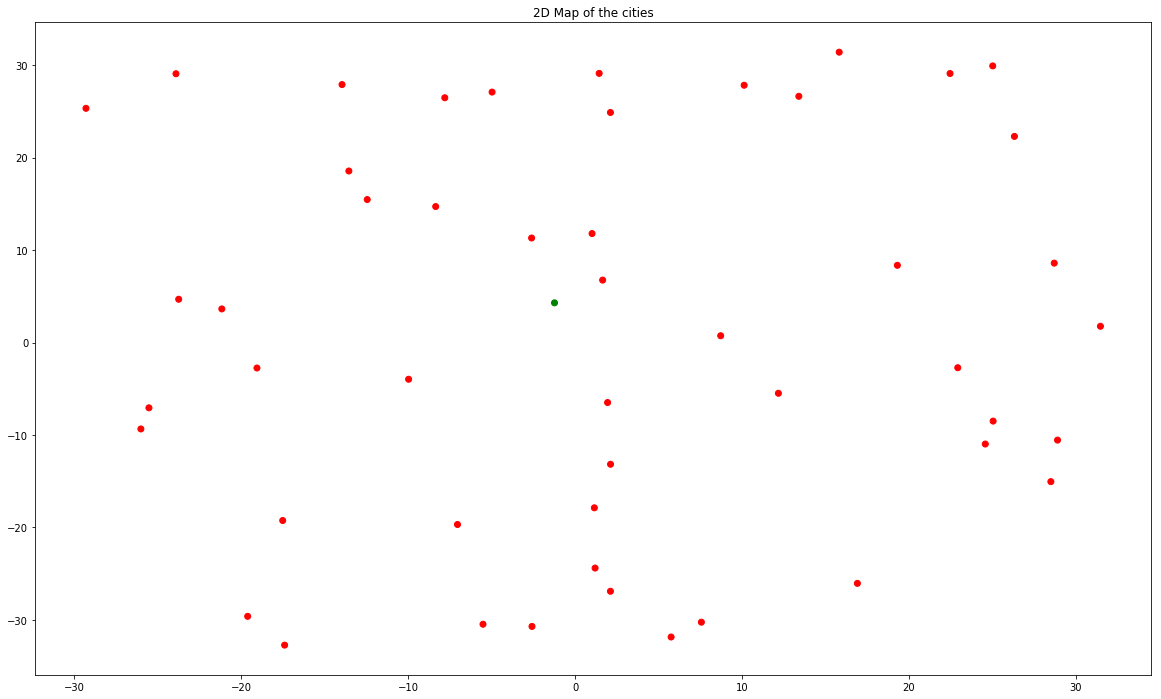

In [66]:
obj = PSO()
obj.run_pso()